In [1]:
# %matplotlib notebook
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import requests
import zipfile
from bs4 import BeautifulSoup
from urllib.request import Request, urlopen
from datetime import date, timedelta

In [2]:
#Limit dates to plot
N_days=60 # number of days to include
#N_days=150 # number of days to include
bad_cutoff=4000 # minimum number of tests to consider good
#bad_cutoff=100

In [3]:
# Read datafile

#define the file to read
datafolder=Path("data/")
datafile=datafolder / "Municipality_cases_time_series.csv"

# Converts index to date
# Notice handeling of danish format of the numbers (both decimal and thousands)
df_cases=pd.read_csv(datafile,  sep=';', parse_dates=['date_sample'], index_col=['date_sample'],error_bad_lines=False, engine='python', decimal=',', thousands='.')

# look at Copenhagen
df_cases_sel=df_cases['Copenhagen']

In [4]:
#define the file to read
datafolder=Path("data/")
datafile=datafolder / "Municipality_tested_persons_time_series.csv"

# Skips last two lines (which does not convert to date) and converts index to date
# Notice handeling of danish format of the numbers (both decimal and thousands)
df_tests=pd.read_csv(datafile,  sep=';', parse_dates=['PrDate_adjusted'], index_col=['PrDate_adjusted'],error_bad_lines=False, engine='python', decimal=',', thousands='.')

df_tests_sel=df_tests['Copenhagen']

In [5]:
# merge data based on dates (CHECK the result)
df=df_cases_sel.to_frame().merge(df_tests_sel.to_frame(),left_index=True, right_index=True)
df=df.rename(columns={"Copenhagen_x": "NewPositive", "Copenhagen_y": "NotPrevPos"})
df

,NewPositive,NotPrevPos
2020-02-26,0,4
2020-02-27,1,12
2020-02-28,0,8
2020-03-01,1,9
2020-03-02,1,10
...,...,...
2020-12-12,727,15022
2020-12-13,768,15218
2020-12-14,686,16333
2020-12-15,96,3186


In [6]:
# calculate some more numbers

# Positive emperical scaled by number of tests to power of 0.7  
# This scaling is based on results in 
# SSI "Ekspertrapport af d. 23. oktober 2020 Incidens og fremskrivning af COVID-19 tilfælde"
# https://www.ssi.dk/-/media/ssi-files/ekspertrapport-af-den-23-oktober-2020-incidens-og-fremskrivning-af-covid19-tilflde.pdf?la=da
def calcScaledNumber (row):
    if row.NotPrevPos > 0 :
        return row.NewPositive / (row.NotPrevPos**0.7) * 10000**0.7 / 10000 *100#Normalized positiv procent to 50000 tests
    else:
        return 0
    
df['ScaledNumber']=df.apply(lambda row: calcScaledNumber(row), axis=1)    

# Recalculate Positiv procent to get more decimals for plotting
def calcPosPct (row):
    if row.NotPrevPos > 0 :
        return row.NewPositive / row.NotPrevPos * 100
    else:
        return 0
df['PosPct']=df.apply(lambda row: calcPosPct(row), axis=1)

In [7]:
# for easy plot make a sub data frame with selected number of days 
df_sel=df[date.today()-timedelta(days=N_days):]

# and make index for "bad" datapoints
bad_idx=df_sel['NotPrevPos']<bad_cutoff

In [8]:
# define a common title including date from file
#Define date of today used format
d=date.today()
date_str=d.strftime("%d%m%Y")
title_str='SSI COVID-19 data, tilfælde opgjort på prøvetagningsdato \n KØBENHAVN \n' 
title_str += date_str

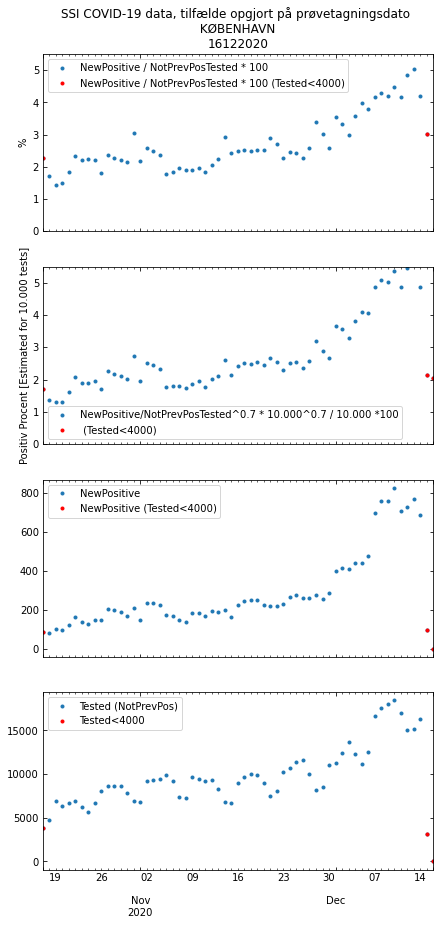

In [9]:
axs=[None]*4 #define axs list as empty 4 entries
fig = plt.figure(figsize=(7, 15))
axs[0] = plt.subplot(411)
axs[1] = plt.subplot(412,sharex=axs[0])
axs[2] = plt.subplot(413,sharex=axs[0])
axs[3] = plt.subplot(414,sharex=axs[0])


df_sel.plot(ax=axs[0],y='PosPct',title=title_str,label='NewPositive / NotPrevPosTested * 100',style='.');
df_sel[bad_idx].plot(ax=axs[0],y='PosPct',style='.',color='red',label='NewPositive / NotPrevPosTested * 100 (Tested<'+ str(bad_cutoff) + ')');
axs[0].set_ylabel("%");
axs[0].set_ylim(0,5.5)
axs[0].tick_params(which='both', bottom=True, top=True, left=True, right=True, direction='in')

df_sel.plot(ax=axs[1], y='ScaledNumber',label='NewPositive/NotPrevPosTested^0.7 * 10.000^0.7 / 10.000 *100',style='.');
df_sel[bad_idx].plot(ax=axs[1],y='ScaledNumber',style='.',color='red', label=' (Tested<'+ str(bad_cutoff) + ')');
axs[1].set_ylabel("Positiv Procent [Estimated for 10.000 tests]");
axs[1].tick_params(which='both', bottom=True, top=True, left=True, right=True, direction='in')
axs[1].set_ylim(0,5.5)


df_sel.plot(ax=axs[2],y='NewPositive',style='.');
df_sel[bad_idx].plot(ax=axs[2],y='NewPositive',style='.',color='red',label='NewPositive (Tested<'+ str(bad_cutoff) + ')');
axs[2].tick_params(which='both', bottom=True, top=True, left=True, right=True, direction='in')

df_sel.plot(ax=axs[3],y='NotPrevPos',label='Tested (NotPrevPos)',style='.');
df_sel[bad_idx].plot(ax=axs[3],y='NotPrevPos',style='.',color='red',label='Tested<'+ str(bad_cutoff) + '');
axs[3].tick_params(which='both', bottom=True, top=True, left=True, right=True, direction='in')


In [10]:
bad_idx

2020-10-17     True
2020-10-18    False
2020-10-19    False
2020-10-20    False
2020-10-21    False
              ...  
2020-12-12    False
2020-12-13    False
2020-12-14    False
2020-12-15     True
2020-12-16     True
Name: NotPrevPos, Length: 61, dtype: bool